In [1]:
"""
A 1000 run of the gillespied function, with constant inputs 
"""

"A 1000 run of the gillespied function, with constant inputs \n"

In [2]:
using Distributed, Plots, DelimitedFiles, KernelDensity

In [3]:
length(Sys.cpu_info())
addprocs(4) ;

In [5]:
@everywhere using Random, Distributions

In [6]:
@everywhere struct SPN
    init::Vector{Real}
    rates::Vector{Real}
    Stoichiometry_matrix::Array{Real}
    function SPN(init, rates, Stoichiometry_matrix)
        new(init, rates, Stoichiometry_matrix)
    end
end

In [7]:
@everywhere init(N::SPN) = Float64.(N.init)
@everywhere rates(N::SPN) = Float64.(N.rates)
@everywhere StoiMat(N::SPN) = Float64.(N.Stoichiometry_matrix)

In [8]:
@everywhere function hazard(x::Vector{Float64},th::Vector{Float64},c0::Float64)::Vector{Float64}
    error = sum(x) - c0
    W = x[1]
    M = x[2]
    k = th[1:5]
    Kc = th[6:7]
    if error > 0
        k1 = 2*k[1]/(1+exp(error*Kc[1]))
        k2 = 2*k[2]/(1+exp(error*Kc[1]))
        return [W,M,W,M,W] .* [k1, k2, th[3], th[4], th[5]]
    else 
        k1 = k[1]*(1+exp(-error*Kc[2]))/2
        k2 = k[2]*(1+exp(-error*Kc[2]))/2
        return [W,M,W,M,W] .* [k1, k2, th[3], th[4], th[5]]
    end
end

In [9]:
@everywhere const post = [[2,0,0,0,1] [0,2,0,0,1]]
@everywhere const pre = [[1,0,1,0,1] [0,1,0,1,0]]
@everywhere const S = post - pre
@everywhere const k = [3.06e-8, 3.06e-8, 3.06e-8, 3.06e-8, 0.0, 2e-3, 2e-3];

In [10]:
@everywhere function gen_inits(μ::Real, σ::Real, α::Real, β::Real)::Vector{Float64}
    CC = rand(Normal(μ, σ))
    hh = rand(Beta(α, β))
    return round.( [CC*(1-hh), CC*hh] )
end

In [47]:
@everywhere function transform_summ(popdym)::Array{Float64, 2}
    copy_num = popdym[:,1] .+ popdym[:,2]
    
    nonzero_idx = copy_num .!= 0.0
    mut_load = fill(NaN, length(copy_num))
    mut_load[nonzero_idx] .= popdym[nonzero_idx, 2] ./ copy_num[nonzero_idx]
    
    return hcat(copy_num, mut_load)
end

In [45]:
@everywhere function gillespied(N::SPN, Tmax::Real, dtout::Real)::Array{Float64, 2}
    k = rates(N)
    x = init(N)
    Nout = trunc(Int, Tmax/dtout)
    S = StoiMat(N)
    xmat = Array{Float64, 2}(undef, (length(x),Nout+1))
    xmat[:,1] = x
    i = 1
    tt = 0.0
    target = 0.0
    c0 = sum(x)
    while i <= Nout
        h = hazard(x, k, c0)
        h0 = sum(h)
        if h0<1e-10
            xmat[:,i:(Nout+1)] = zeros(2,Nout-i+2)
            return transform_summ(xmat')
        else
            Exp = Exponential(1/h0)
            tt = tt + rand(Exp)
        end
        while tt>=target && i<=Nout
            i += 1
            xmat[:,i] = x
            target += dtout
        end
        Cat = Categorical(h/h0)
        r = rand(Cat)
        x += S'[:,r]
    end
    return transform_summ(xmat')
end

In [14]:
Nsim = 1000
Tmax = 80*365*24*3600
step_out = 7*24*3600 ; 

In [48]:
spn = SPN([100,100], k, S)
@time tt = gillespied(spn, Tmax, step_out);
"""
a single run takes ~0.03 seconds
"""

  0.208719 seconds (954.47 k allocations: 64.598 MiB, 7.13% gc time, 87.98% compilation time)


"a single run takes ~0.03 seconds\n"

In [16]:
"""
simulations_single = Array{Float64}(undef, n(Ntest), 2, Nsim)
@time for i=1:Nsim
    simulations_single[:,:,i] = gillespied(Ntest)
end
This is a lot slower (doubly slow) than the previous version without the SPN structure
For 1000 simulations 26.536 seconds
"""

"simulations_single = Array{Float64}(undef, n(Ntest), 2, Nsim)\n@time for i=1:Nsim\n    simulations_single[:,:,i] = gillespied(Ntest)\nend\nThis is a lot slower (doubly slow) than the previous version without the SPN structure\nFor 1000 simulations 26.536 seconds\n"

In [17]:
#summ_single = raw_to_summ(simulations_single);
#qnts_single = quantiles(summ_single, [0.025,0.1,0.5,0.9,0.975]) ;

In [82]:
# The arguments are: 1) a function 'f' and 2) a list with the input.
@everywhere function par_map(Nsim, f, SPN, Tmax, dtout)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Vector{Array{Float64, 2}}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = remotecall_fetch(f, p, SPN, Tmax, dtout)
                    end
                end
            end
        end
    end
    output
end

In [83]:
@time simulations = par_map(Nsim, gillespied, spn, Tmax, step_out) ;
"""
simple simulation: ~ 7.5 seconds
4 workers, 1000 simulations
"""

  7.076407 seconds (144.91 k allocations: 69.520 MiB, 0.72% compilation time)


"simple simulation: ~ 7.5 seconds\n4 workers, 1000 simulations\n"

In [134]:
@everywhere function quantiles(sims, p)
    """
    returns quantile summaries from simulations
    """
    Nsim = length(sims) # Nsim: number of simulations
    n = size(sims[1])[1] # length of one simulation
    out = Vector{Array{Float64,2}}(undef,2)
    out[1] = Array{Float64, 2}(undef, n,length(p))
    out[2] = Array{Float64, 2}(undef, n,length(p))
    for t=1:n
        out[1][t,:] = quantile([sims[i][t,1] for i=1:Nsim if !isnan(sims[i][t,1])], p)
        out[2][t,:] = quantile([sims[i][t,2] for i=1:Nsim if !isnan(sims[i][t,2])], p)
    end
    out
end

In [138]:
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [139]:
mkpath("Simulations") ;

In [150]:
writedlm("Simulations/CN_qnt_gill_jl.txt", sims_qntl[1])
writedlm("Simulations/ML_qnt_gill_jl.txt", sims_qntl[2]) ;

In [159]:
function distributions_t(sims, t, Tmax, dtout)
    t_tot = [dtout:dtout:Tmax;]
    Nsim = length(sims)
    nt = length(t)
    sim_t = Vector{Array{Float64,2}}(undef, 2)
    for i=1:Nsim
        for j=1:nt
            
            sim_t[1][i,j] = sims[i][findall(x->x==t[j], t_tot),1][1]
            sim_t[2][i,j] = sims[i][findall(x->x==t[j], t_tot),2][1]
        end
    end
    sim_t
end ;


In [160]:
dist_sims = distributions_t(simulations, [10:10:80;]*365*24*3600, Tmax, step_out) ; 

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

In [143]:
writedlm("Simulations/CN_ts_gill_jl.txt", dist_sims[:,:,1])
writedlm("Simulations/ML_ts_gill_jl.txt", dist_sims[:,:,2])

LoadError: UndefVarError: dist_sims not defined

In [144]:
"""
Time taken 
"""

"Time taken \n"

In [145]:
@everywhere function par_times(Nsim, f, SPN, Tmax, dtout)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Array{Float64}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = @elapsed remotecall_fetch(f, p, SPN, Tmax, dtout)
                    end
                end
            end
        end
    end
    output
end

In [161]:
sim_times = par_times(Nsim, gillespied, spn, Tmax, step_out) 

mkpath("Simulations")
writedlm("Simulations/gill_times.txt", sim_times)

In [162]:
dens = kde(sim_times)
density_points = hcat(dens.x, dens.density) ;

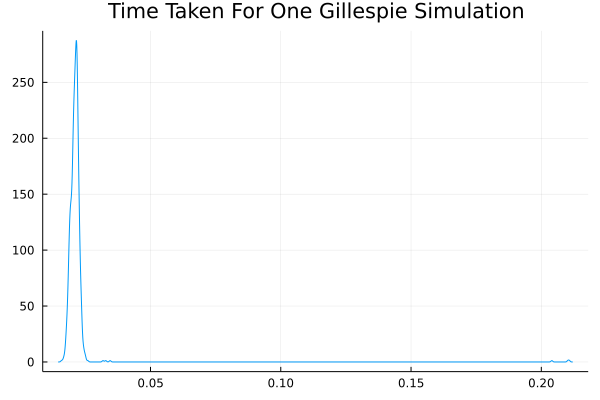

In [163]:
plot(density_points[:,1], density_points[:,2], legend=false, title="Time Taken For One Gillespie Simulation" )